# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=1l7bHyrjzq839zVZE06cfdDksLabCN2hg"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Future Sales Time-series Prediction 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=1vi45x-LGEzwvJoQstierOC1QZ11QQUmS)

![alt text](https://drive.google.com/uc?id=1eLLebiXwkN6x1dpsopQmkVNkR9zAYL7H)

![alt text](https://drive.google.com/uc?id=1a_q_DC8NyGBmcrxE0sGV4r6Hl-0w6G0K)

![alt text](https://drive.google.com/uc?id=1hNE0Wwc_bCCIO-AUAi6Xqo_9Bf1Xbh2o)

![alt text](https://drive.google.com/uc?id=1lQVgHsXn4Ur61dgYul1G-CmseLLUCEOB)

# TASK #2: IMPORT LIBRARIES AND DATASET 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import datetime
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


TASK #2.1: IMPORT SALES TRAINING DATA

In [3]:
# You have to include the full link to the csv file containing your dataset
# train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sales forecasting/train.csv')
train = pd.read_csv("train.csv")
train.head()

/var/folders/23/9f15z0c11jz_sy9hlr5w468h0000gn/T/ipykernel_11958/1134450754.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:

# almost a million observation 
# 1115 unique stores 
# Note that sales is the target variable (that's what we are trying to predict) 

# Id: transaction ID (combination of Store and date) 
# Store: unique store Id
# Sales: sales/day, this is the target variable 
# Customers: number of customers on a given day
# Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
# Promo: describes if store is running a promo on that day or not
# StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
# SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
# Data Source: https://www.kaggle.com/c/rossmann-store-sales/data



In [6]:
pd.set_option('display.max_colwidth', None)
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

TASK #2.2: IMPORT STORE INFORMATION DATA

In [8]:

# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# store = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sales forecasting/store.csv')
store = pd.read_csv("store.csv")
store.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
# Let's do the same for the store_info_df data
# Note that the previous dataframe includes the transactions recorded per day (in millions)
# This dataframe only includes information about the unique 1115 stores that are part of this study 
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [11]:
# on average, the competition distance is 5404 meters away (5.4 kms)

# TASK #3: EXPLORE DATASET

TASK #3.1: EXPLORE SALES TRAINING DATA

In [12]:
# Let's see if we have any missing data, luckily we don't!
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [21]:
# Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
# Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation) 
# Stores are open ~80% of the time
# Data is equally distributed among all stores (no bias)
# Promo #1 was running ~40% of the time 
# Average sales around 5000-6000 Euros
# School holidays are around ~18% of the time

train.select_dtypes(include=['float64','int64']).columns[1:]

Index(['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday'], dtype='object')

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


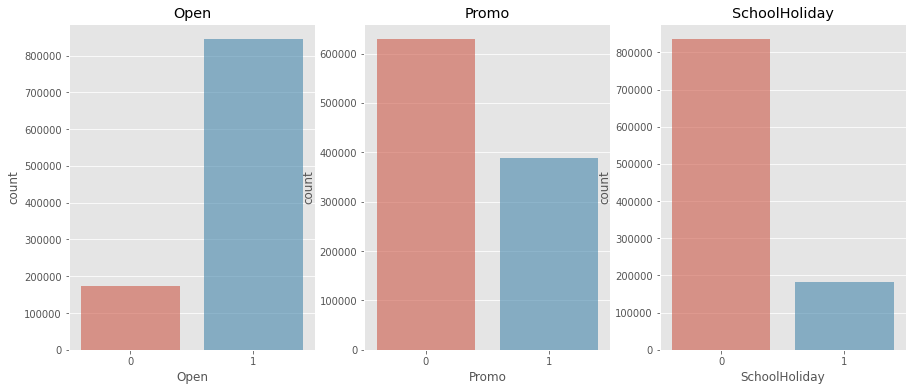

In [34]:
def _plot_numeric_classes(df, col):
    sns.countplot(df[col], alpha = 0.6)

def _distribution_numeric(df, numeric_cols, row=1, col=3, figsize=(15, 6)):
    assert row*(col-1) < len(numeric_cols)
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(df, numeric_cols[i-1])
        plt.title(numeric_cols[i-1])
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
plt.style.use("ggplot")
numeric_cols = ['Open', 'Promo', 'SchoolHoliday']
_distribution_numeric(train, numeric_cols)

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


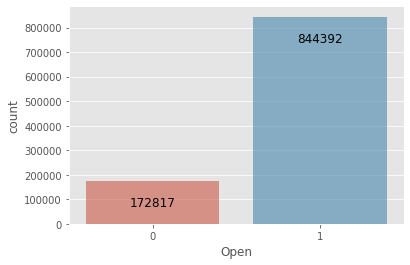

In [27]:
# Let's see how many stores are open and closed! 
# Count the number of stores that are open and closed
ax = sns.countplot(train["Open"], alpha = 0.6)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', size=10)

In [35]:
# only keep open stores and remove closed stores
train1 = train[train["Open"] == 1]
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844392 non-null  int64 
 1   DayOfWeek      844392 non-null  int64 
 2   Date           844392 non-null  object
 3   Sales          844392 non-null  int64 
 4   Customers      844392 non-null  int64 
 5   Open           844392 non-null  int64 
 6   Promo          844392 non-null  int64 
 7   StateHoliday   844392 non-null  object
 8   SchoolHoliday  844392 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 64.4+ MB


In [ ]:
# Let's drop the open column since it has no meaning nbarplot

In [37]:
train1.drop(columns = "Open", inplace = True)

/var/folders/23/9f15z0c11jz_sy9hlr5w468h0000gn/T/ipykernel_11958/823447404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1.drop(columns = "Open", inplace = True)


<AxesSubplot:xlabel='Sales', ylabel='Count'>

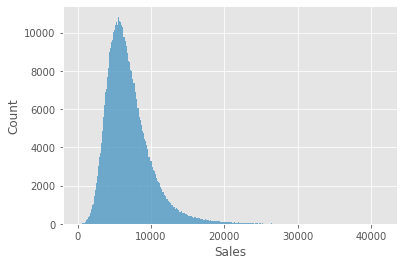

In [41]:
# Average sales = 6955 Euros,	average number of customers = 762	(went up)
sns.histplot(train1["Sales"])

TASK #3.2: EXPLORE STORES INFORMATION DATA

In [43]:
# Let's see if we have any missing data in the store information dataframe!
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
# Let's take a look at the missing values in the 'CompetitionDistance'
# Only 3 rows are missing 


In [ ]:
# Let's take a look at the missing values in the 'CompetitionOpenSinceMonth'
# many rows are missing = 354 (almost one third of the 1115 stores)


In [ ]:
# It seems like if 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is set to zero
# There are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing
# Let's set these values to zeros 


In [ ]:
# There are 3 rows with 'competitionDistance' values missing, let's fill them up with with average values of the 'CompetitionDistance' column


In [ ]:
# half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m (3 kms away)

TASK #3.3: EXPLORE MERGED DATASET 

In [ ]:
# Let's merge both data frames together based on 'store'


In [ ]:

# customers and promo are positively correlated with the sales 
# Promo2 does not seem to be effective at all 

In [ ]:

# Customers/Prmo2 and sales are strongly correlated 

In [ ]:
# Let's separate the year and put it into a separate column 


In [ ]:
# Let's do the same for the Day and Month


In [ ]:
# Let's take a look at the average sales and number of customers per month 
# 'groupby' works great by grouping all the data that share the same month column, then obtain the mean of the sales column  
# It looks like sales and number of customers peak around christmas timeframe



In [ ]:
# Let's take a look at the sales and customers per day of the month instead
# Minimum number of customers are generally around the 24th of the month 
# Most customers and sales are around 30th and 1st of the month



In [ ]:
# Let's do the same for the day of the week  (note that 7 = Sunday)



# TASK #4: UNDERSTAND THE INTUITION BEHIND FACEBOOK PROPHET

![alt text](https://drive.google.com/uc?id=1I4lBgLaqERF_-lpGYLuht02wJmwcLGG-)

![alt text](https://drive.google.com/uc?id=1CZ24f-TbnRzaXV9Arke0fNTUm7Kon1gK)

![alt text](https://drive.google.com/uc?id=16gaoTeeuU5PxNZRHt8n2XyFJ52ft1xb7)

# TASK #5: TRAIN THE MODEL PART A

In [ ]:
# import prophet 

# TASK #6: TRAIN THE MODEL PART B


   - StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
   - SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
  






In [ ]:
# Get all the dates pertaining to school holidays 


In [ ]:
# Get all the dates pertaining to state holidays 


In [ ]:
# concatenate both school and state holidays 


In [ ]:
# Let's make predictions using holidays for a specific store


# EXCELLENT JOB!